###  **Importing Important Libraries**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#### **Loading the dataset**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/0shanx/0shanx/refs/heads/main/marriage_data_india.csv')

#### **Define Features and Target**

In [4]:
X = df.drop(columns=['ID', 'Marriage_Type'])
y = df['Marriage_Type']  # Love / Arranged

#### **Train/Test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

#### **Preprocessing Pipeline**

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['Age_at_Marriage', 'Years_Since_Marriage', 'Children_Count']
categorical_features = [
    'Gender', 'Education_Level', 'Caste_Match', 'Religion',
    'Parental_Approval', 'Urban_Rural', 'Dowry_Exchanged',
    'Inter-Caste', 'Inter-Religion'
]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])


#### **Model Pipelines**

In [15]:
pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])

pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ))
])

pipe_svc = Pipeline([
    ('prep', preprocessor),
    ('clf', SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ))
])

#### **Train Models**

In [16]:
# Fit each model
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_svc.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age_at_Marriage',
                                                   'Years_Since_Marriage',
                                                   'Children_Count']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender', 'Education_Level',
                                                   'Caste_Match', 'Religion',
                                                   'Parental_Approval',
                                                   'Urban_Rural',
                                                   'Dowry_Exchanged',
                                                   'Inter-Caste',
                                                   'Inter-Religion'])])),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

####  **Predict on Test Set**

In [17]:
y_pred_lr  = pipe_lr.predict(X_test)
y_pred_rf  = pipe_rf.predict(X_test)
y_pred_svc = pipe_svc.predict(X_test)

# For ROC-AUC (optional), get probabilities:
y_prob_lr  = pipe_lr.predict_proba(X_test)[:, 1]
y_prob_rf  = pipe_rf.predict_proba(X_test)[:, 1]
y_prob_svc = pipe_svc.predict_proba(X_test)[:, 1]


### **Evaluation Metrics**

In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import pandas as pd


y_pred_lr  = pipe_lr.predict(X_test)
y_pred_rf  = pipe_rf.predict(X_test)
y_pred_svc = pipe_svc.predict(X_test)

y_prob_lr  = pipe_lr.predict_proba(X_test)[:, 1]
y_prob_rf  = pipe_rf.predict_proba(X_test)[:, 1]
y_prob_svc = pipe_svc.predict_proba(X_test)[:, 1]


models = {
    'Logistic Regression': (y_pred_lr, y_prob_lr),
    'Random Forest':       (y_pred_rf, y_prob_rf),
    'Support Vector Machine': (y_pred_svc, y_prob_svc)
}

metrics = []
for name, (y_pred, y_prob) in models.items():
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, pos_label='Love')
    rec   = recall_score(y_test, y_pred, pos_label='Love')
    f1    = f1_score(y_test, y_pred, pos_label='Love')
    roc   = roc_auc_score(y_test.map({'Arranged':0,'Love':1}), y_prob)
    cm    = confusion_matrix(y_test, y_pred, labels=['Arranged','Love'])
    metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc,
        'Confusion Matrix': cm.tolist()
    })

df_metrics = pd.DataFrame(metrics).set_index('Model')
print(df_metrics[['Accuracy','Precision','Recall','F1-Score','ROC-AUC']])
# If you want to inspect confusion matrices separately:
for name, row in df_metrics.iterrows():
    print(f"\n{name} Confusion Matrix:\n", row['Confusion Matrix'])


                        Accuracy  Precision    Recall  F1-Score   ROC-AUC
Model                                                                    
Logistic Regression       0.5035   0.398767  0.487437  0.438666  0.512129
Random Forest             0.5745   0.419825  0.180905  0.252853  0.510183
Support Vector Machine    0.5055   0.396791  0.466080  0.428654  0.493306

Logistic Regression Confusion Matrix:
 [[619, 585], [408, 388]]

Random Forest Confusion Matrix:
 [[1005, 199], [652, 144]]

Support Vector Machine Confusion Matrix:
 [[640, 564], [425, 371]]


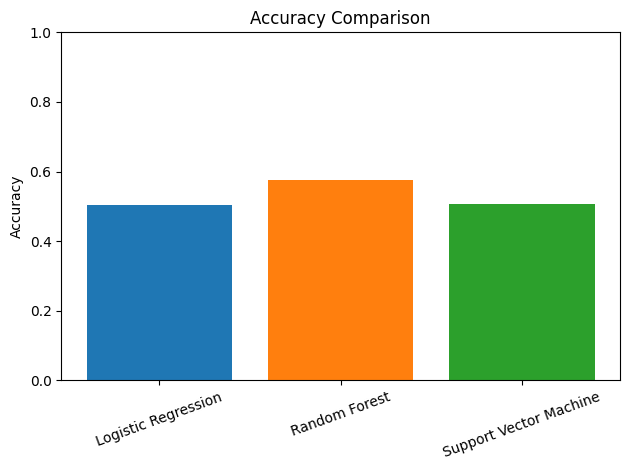

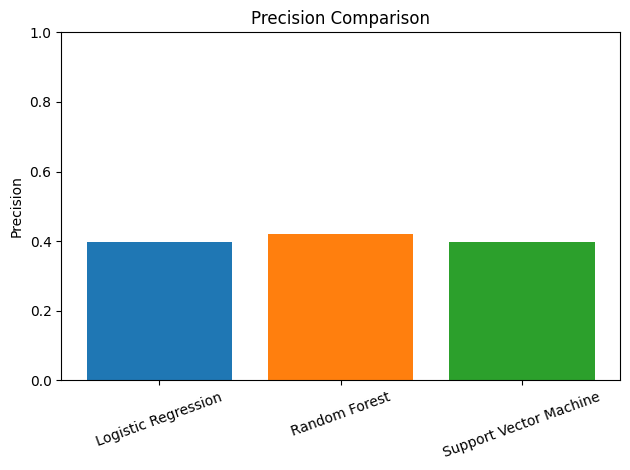

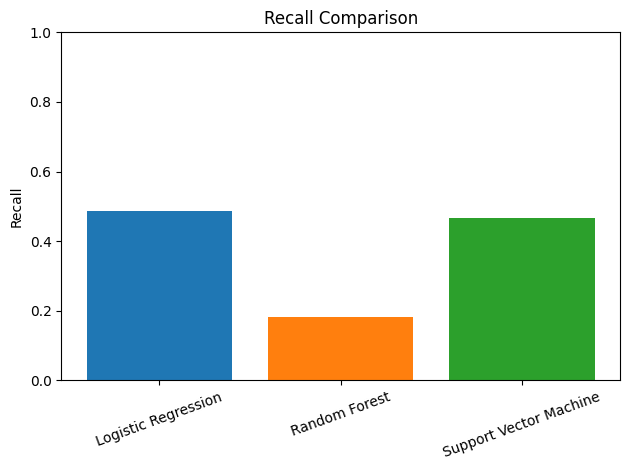

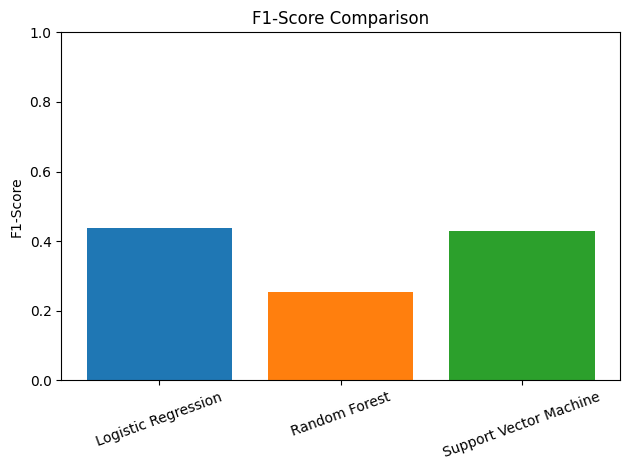

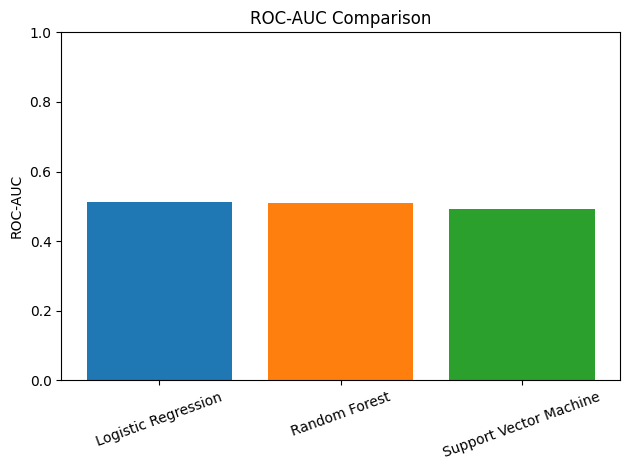

In [ ]:
import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green']

plot_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for metric in plot_metrics:
    plt.figure()
    models = df_metrics.index.tolist()
    scores = df_metrics[metric].values

    plt.bar(models, scores, color=colors)
    
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
